In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import torch
from neuralop.data.datasets.custom_darcy import CustomDarcyDataset, load_darcy_flow
import matplotlib.pyplot as plt
from neuralop.models import CNO2d
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

In [2]:
# resolution = 64

# train_loader, test_loaders, data_processor = load_darcy_flow(
#     root_dir="./data/",
#     dataset_name='darcy_ZD_PWC',
#     n_train=1000,
#     n_tests=[50],
#     batch_size=20,
#     test_batch_sizes=[50],
#     train_resolution=resolution,
#     test_resolutions=[resolution]
# )

resolution = 256
tau = 3
alpha = 2

train_loader, test_loaders, data_processor = load_darcy_flow(
    root_dir="./data/",
    dataset_name='darcy',
    n_train=1000,
    n_tests=[50],
    batch_size=10,
    test_batch_sizes=[10],
    train_resolution=resolution,
    test_resolutions=[resolution],
    train_data_setting={'tau': tau, 'alpha': alpha, 'boundary': 'ZD'},
    test_data_settings=[{'tau': tau, 'alpha': alpha, 'boundary': 'ZD'}],
)

Loading test db for resolution 256 with 50 samples 


In [3]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
        
model = CNO2d(
    in_dim=1,           
    out_dim=1,       
    size=resolution,     
    N_layers=4,     
    N_res=2,          
    N_res_neck=4,      
    channel_multiplier=24,
    use_bn=True,
)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 4063389 parameters.


In [4]:
n_epochs = 200
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [5]:
import wandb
from datetime import datetime

wandb.init(
    project='Samsung_Project',
    name=f'CNO_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tjwoals217 (tjwoals217-Chung-Ang University) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [6]:
trainer = Trainer(model=model, 
                  n_epochs=n_epochs,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=True,
                  eval_interval=1,
                  use_distributed=False,
                  verbose=True)

trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 1000 samples
Testing on [50] samples         on resolutions [256].
Raw outputs of shape torch.Size([10, 1, 256, 256])
[0] time=16.15, avg_loss=0.5105, train_err=5.1048
Eval: 256_h1=0.7877, 256_l2=0.8732
[1] time=15.84, avg_loss=0.2629, train_err=2.6292
Eval: 256_h1=0.7558, 256_l2=0.5208
[2] time=15.86, avg_loss=0.2082, train_err=2.0817
Eval: 256_h1=0.2224, 256_l2=0.1862
[3] time=15.93, avg_loss=0.1831, train_err=1.8312
Eval: 256_h1=0.3617, 256_l2=0.2221
[4] time=15.93, avg_loss=0.1667, train_err=1.6675
Eval: 256_h1=0.1596, 256_l2=0.0856
[5] time=15.93, avg_loss=0.1543, train_err=1.5430
Eval: 256_h1=0.1622, 256_l2=0.0833
[6] time=15.93, avg_loss=0.1449, train_err=1.4488
Eval: 256_h1=0.1279, 256_l2=0.0501
[7] time=15.90, avg_loss=0.1349, train_err=1.3492
Eval: 256_h1=0.1906, 256_l2=0.0879
[8] time=15.96, avg_loss=0.1267, train_err=1.2667
Eval: 256_h1=0.1538, 256_l2=0.0694
[9] time=15.96, avg_loss=0.1177, train_err=1.1773
Eval: 256_h1=0.1712, 256_l2=0.0735
[10] time=15.96, avg

{'train_err': 0.23587607228088137,
 'avg_loss': 0.023587607228088135,
 'avg_lasso_loss': None,
 'epoch_train_time': 15.995490100001916,
 '256_h1': tensor(0.0187, device='cuda:3', dtype=torch.float64),
 '256_l2': tensor(0.0069, device='cuda:3', dtype=torch.float64)}

In [7]:
wandb.finish()

256_h1,▅█▄▃▃▂▂▂▂▂▂▂▃▂▂█▃▂▁▁▁▁▁▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
256_l2,▅▂▂▂▂▂▂▂▁▂▁▁▁▁▁█▁▁▁▄▅▃▃▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_loss,█▆▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,████████▇▇▇▇▇▇▇▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁
time,▁▂▃▅▆▇▆▇▆▇▇▇▅▇▇▇▇▆▇▇▇█▇▇▇▆▆▆▆▅▆▆▆▆▅▅▅▄▅▅
train_err,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
256_h1,0.01869
256_l2,0.0069
avg_loss,0.02359
lr,0
time,15.99549


L2 error (0) : 0.01883132694671207
L2 error (1) : 0.006874538126127999
L2 error (2) : 0.0037517933418934704


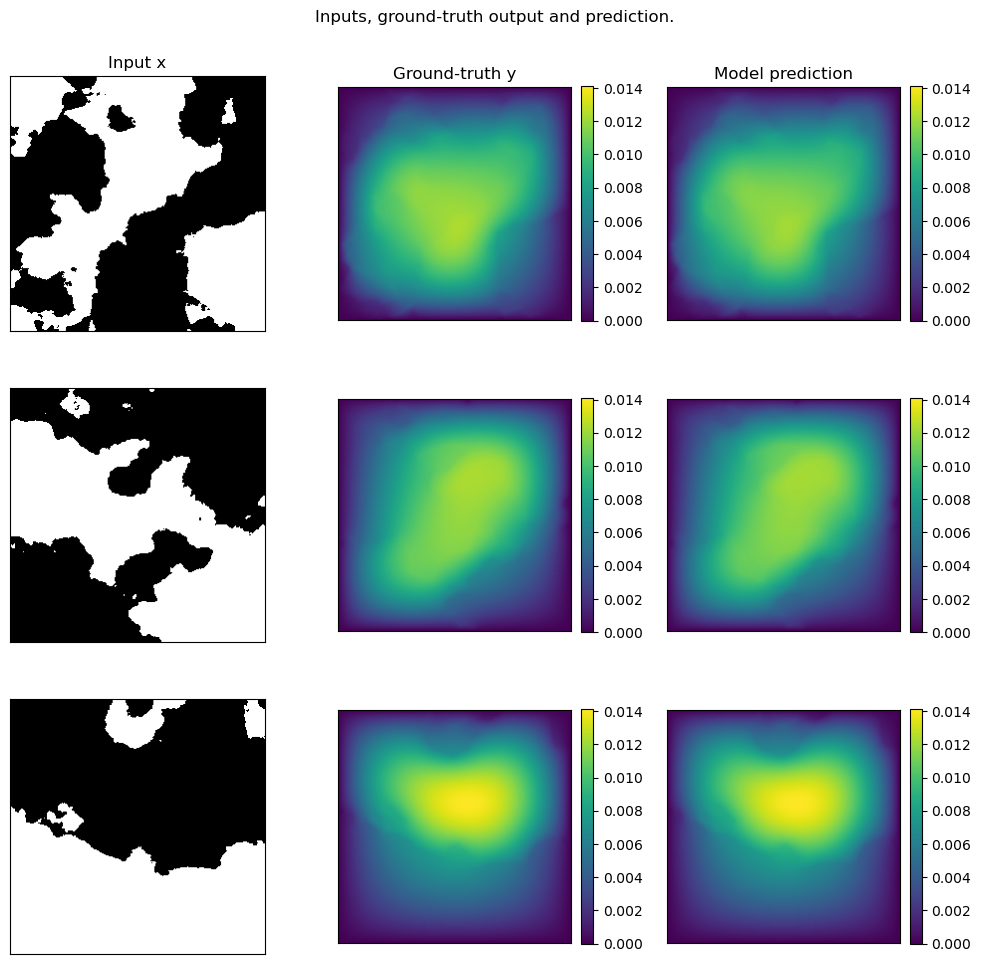

In [8]:
test_samples = test_loaders[resolution].dataset

# Step 1: Compute global min and max for consistent color scaling
vmin, vmax = float('inf'), float('-inf')
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)

    x = data['x']
    y = data['y']
    out = model(x.unsqueeze(0))

    y = data_processor.out_normalizer.inverse_transform(y).squeeze().detach()
    out = data_processor.out_normalizer.inverse_transform(out).squeeze().detach()

    vmin = min(vmin, y.min().item(), out.min().item())
    vmax = max(vmax, y.max().item(), out.max().item())

# Step 2: Plot with consistent vmin/vmax and add colorbars
fig = plt.figure(figsize=(10, 10))

for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)

    x = data['x'].to(device)
    y = data['y'].to(device)
    out = model(x.unsqueeze(0)).squeeze().detach()

    # y = data_processor.out_normalizer.inverse_transform(y)
    out = data_processor.out_normalizer.inverse_transform(out)

    # Input x
    ax = fig.add_subplot(3, 3, index * 3 + 1)
    im = ax.imshow(x[0].cpu(), cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])
    
    # Ground-truth y
    ax = fig.add_subplot(3, 3, index * 3 + 2)
    im = ax.imshow(y.squeeze().cpu(), vmin=vmin, vmax=vmax)
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Model prediction
    ax = fig.add_subplot(3, 3, index * 3 + 3)
    im = ax.imshow(out.squeeze().cpu(), vmin=vmin, vmax=vmax)
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    print(f'L2 error ({index}) : {torch.norm(out - y) / torch.norm(y)}')

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
plt.show()